In [1]:
from src.rejax.envs.bernoulli_bandit import BernoulliBandit, EnvParams
from rejax import get_algo
from rejax.evaluate import evaluate

import jax
import jax.numpy as jnp
import numpy as np
import yaml

In [2]:
config_path = "/Users/chanb/research/ualberta/sandbox/rejax/configs/custom/bandit.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

In [3]:
algo_name = "ucb"
seed_id = 0
num_seeds = 2

key = jax.random.PRNGKey(seed_id)
keys = jax.random.split(key, num_seeds)
config = config[algo_name]

In [4]:
config

{'agent_kwargs': {'confidence': 1.0},
 'num_envs': 1,
 'total_timesteps': 100000,
 'eval_freq': 1000}

In [5]:
env = BernoulliBandit()
config["env"] = env

env_params = jnp.array([
    [0.9, 0.1],
    [0.1, 0.9],
])

algo_cls = get_algo(algo_name)
algo = jax.vmap(lambda x: algo_cls.create(**config))(keys)
algo = algo.replace(
    env_params=algo.env_params.replace(reward_probs=env_params)
)


def eval_callback(algo, ts, rng):
    act = algo.make_act(ts)
    max_steps = algo.env_params.max_steps_in_episode
    return evaluate(act, rng, env, algo.env_params, 128, max_steps)

algo = algo.replace(
    eval_callback=eval_callback
)

In [6]:
algo

UCB(env=<src.rejax.envs.bernoulli_bandit.BernoulliBandit object at 0x144a84fa0>, env_params=EnvParams(max_steps_in_episode=Array([1, 1], dtype=int32, weak_type=True), reward_probs=Array([[0.9, 0.1],
       [0.1, 0.9]], dtype=float32)), eval_callback=<function eval_callback at 0x1447ffc70>, eval_freq=1000, skip_initial_evaluation=False, total_timesteps=100000, learning_rate=Array([0.0003, 0.0003], dtype=float32, weak_type=True), gamma=Array([0.99, 0.99], dtype=float32, weak_type=True), max_grad_norm=Array([inf, inf], dtype=float32, weak_type=True), num_envs=1, agent=TabularUCB(
    # attributes
    num_arms = 2
    confidence = 1.0
))

In [7]:
vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
ts, (_, returns) = vmap_train(algo, keys)
returns.block_until_ready()

{'params': {'counts': Traced<float32[1,2]>with<DynamicJaxprTrace>, 'q_values': Traced<float32[1,2]>with<DynamicJaxprTrace>, 'timesteps': Traced<float32[]>with<DynamicJaxprTrace>}}


Array([[[1., 1., 1., ..., 1., 0., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 0., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        ...,
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.]]], dtype=float32, weak_type=True)

In [11]:
jax.vmap(lambda x: jax.numpy.mean(x))(returns)

Array([0.89735454, 0.8929455 ], dtype=float32)

In [9]:
returns.shape

(2, 101, 128)

In [10]:
jax.debug.print("{x}", x=ts.agent_ts.params)

{'params': {'counts': Array([[[9.9986e+04, 1.4000e+01]],

       [[2.4000e+01, 9.9976e+04]]], dtype=float32), 'q_values': Array([[[0.8999362 , 0.        ]],

       [[0.20833334, 0.9009866 ]]], dtype=float32), 'timesteps': Array([100000., 100000.], dtype=float32)}}


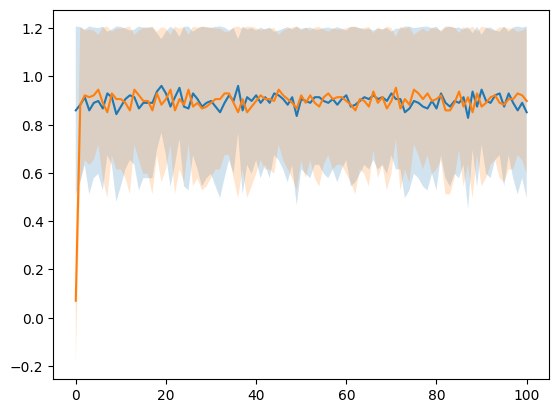

In [15]:
import matplotlib.pyplot as plt

for env_returns in returns:
    xrange = np.arange(len(env_returns))
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1)
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()
